<a href="https://colab.research.google.com/github/Garik-ctrl/AIRemoteZ8028/blob/main/2025_03_22_AIEngineer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Načti data z Kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('train.csv')

In [ ]:
df.info()

In [ ]:
df.head()

## 2) zobrazení počtu chybějících hodnot pro jednotlivé proměnné

In [ ]:
missing=df.isnull().sum() # načtení sumy prázdných hodnot

In [ ]:
missing=missing[missing>0].sort_values(ascending=False)
missing

## 3) doplnění chybějících hodnot

In [ ]:
num_missing=missing.index[df[missing.index].dtypes!='object']
num_missing # vytvoření pole, ve kterém budu mít sloupce k doplnění

In [ ]:
from sklearn.impute import SimpleImputer, KNNImputer

### a) median

In [ ]:
imputer_median=SimpleImputer(strategy='median')
df_median=df.copy()
df_median[num_missing]=imputer_median.fit_transform(df_median[num_missing])

### b) průměr

In [ ]:
imputer_mean=SimpleImputer(strategy='mean')
df_mean=df.copy()
df_mean[num_missing]=imputer_mean.fit_transform(df_mean[num_missing])

### c) KNN, k=5

In [ ]:
imputer_KNN5=KNNImputer(n_neighbors=5)
df_KNN5=df.copy()
df_KNN5[num_missing]=imputer_KNN5.fit_transform(df_KNN5[num_missing])

## 4) Porovnání metod pomocí density grafu

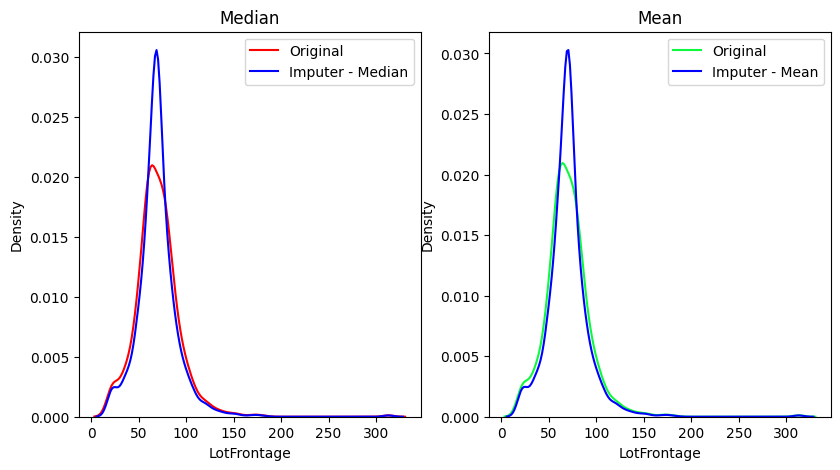

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.kdeplot(df[num_missing[0]], color='r', label='Original')
sns.kdeplot(df_median[num_missing[0]], color='b', label='Imputer - Median')
plt.title('Median')
plt.legend()

plt.subplot(1,3,2)
sns.kdeplot(df[num_missing[0]], color='#0cf93e', label='Original')
sns.kdeplot(df_mean[num_missing[0]], color='b', label='Imputer - Mean')
plt.title('Mean')
plt.legend()


## 5) normalizace číselných proměnných

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

### 5a) Standard

In [ ]:
selected=['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

scaler_std=StandardScaler()
df_std=df_KNN5.copy()
df_std[selected]=scaler_std.fit_transform(df_std[selected])

### b) MinMax

In [ ]:
scaler_minmax=MinMaxScaler() # používáme minamax
df_minmax=df_KNN5.copy()
df_minmax[selected]=scaler_minmax.fit_transform(df_minmax[selected])

### c) Robust

In [ ]:
scaler_robust=RobustScaler() # používáme minamax
df_robust=df_KNN5.copy()
df_robust[selected]=scaler_robust.fit_transform(df_robust[selected])

## 6) porovnání jednotlivých metod pomocí boxplotu

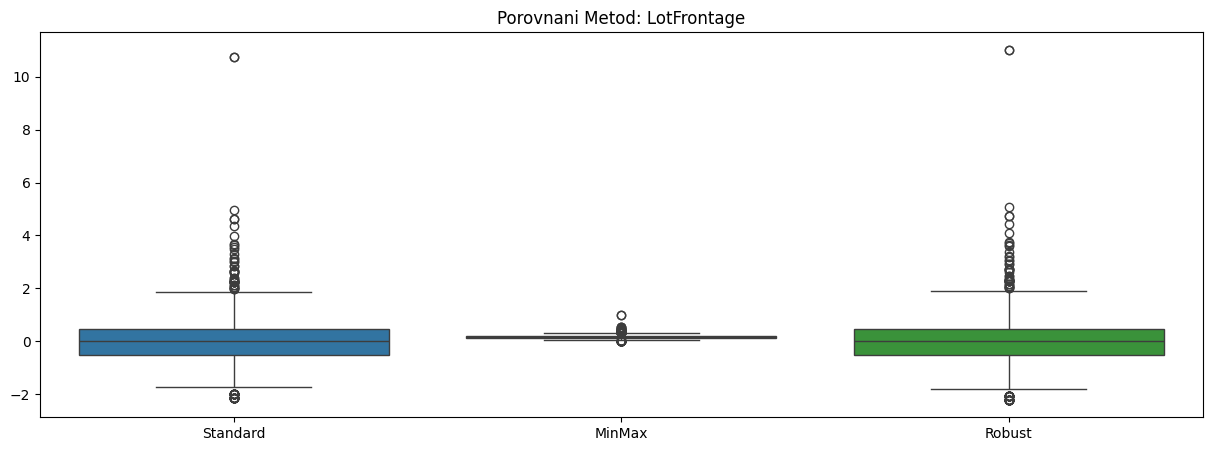

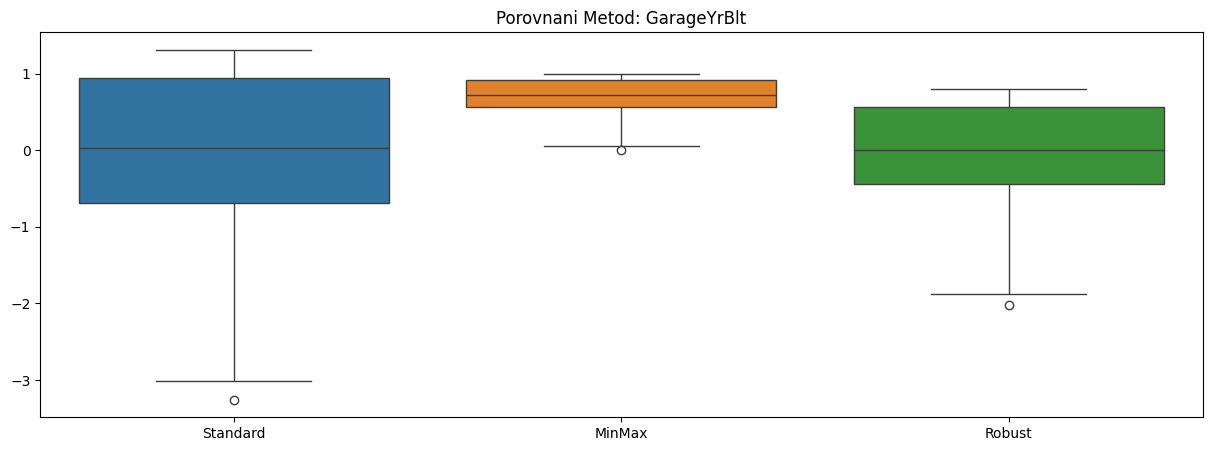

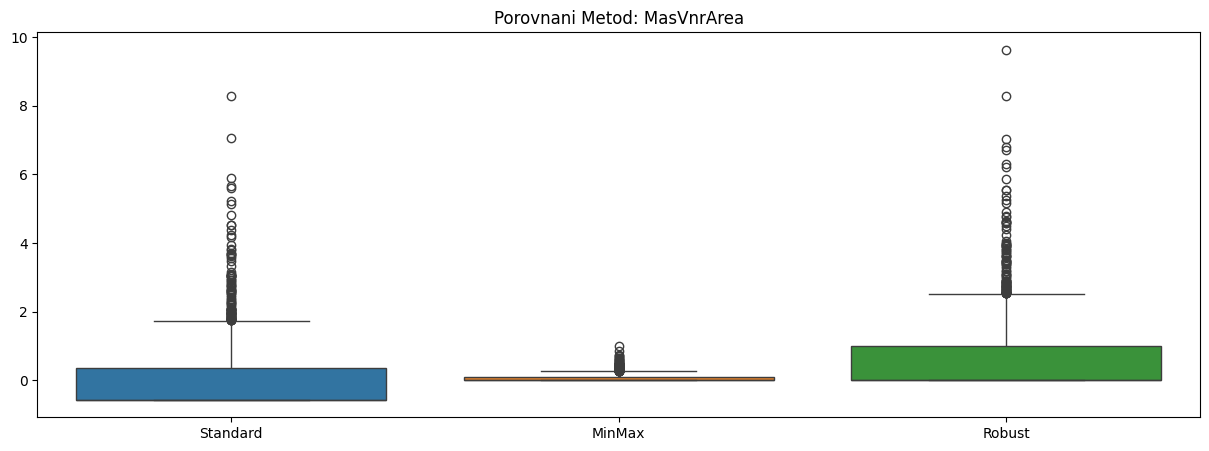

In [ ]:
for col in selected:
  plt.figure(figsize=(15,5))
  sns.boxplot(data=pd.DataFrame({
      'Standard': df_std[col],
      'MinMax': df_minmax[col],
      'Robust': df_robust[col]}))
  plt.title(f'Porovnani Metod: {col}')
  plt.show()